<a href="https://colab.research.google.com/github/samelsamel/MENA-DD-2022-as/blob/main/TF_Transformer_Arabic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transformer model for language understanding

In [3]:
! nvidia-smi

Sun Jan 23 10:53:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial trains a <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer model</a> to translate a [Portuguese to English dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en). This is an advanced example that assumes knowledge of [text generation](https://www.tensorflow.org/text/tutorials/text_generation) and [attention](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

The core idea behind the Transformer model is *self-attention*—the ability to attend to different positions of the input sequence to compute a representation of that sequence. Transformer creates stacks of self-attention layers and is explained below in the sections *Scaled dot product attention* and *Multi-head attention*.

الفكرة الأساسية وراء نموذج  هي * الاهتمام الذاتي * - القدرة على حضور المواقف المختلفة لتسلسل الإدخال لحساب تمثيل هذا  

يُنشئ أكوامًا من طبقات الانتباه الذاتي كما هو موضح أدناه في الأقسام * الاهتمام بالمنتج بنقاط متدرجة * و * الانتباه متعدد الرؤوس *.


A transformer model handles variable-sized input using stacks of self-attention layers instead of [RNNs](https://www.tensorflow.org/text/tutorials/text_classification_rnn) or [CNNs](https://www.tensorflow.org/tutorials/images/cnn). This general architecture has a number of advantages:

* It makes no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8)).
لا يقدم أي افتراضات حول العلاقات الزمنية / المكانية عبر البيانات. هذا مثالي لمعالجة مجموعة من الكائنات

* Layer outputs can be calculated in parallel, instead of a series like an RNN.
يمكن حساب مخرجات الطبقة بالتوازي

* Distant items can affect each other's output without passing through many RNN-steps, or convolution layers (see [Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf) for example).
يمكن أن تؤثر العناصر البعيدة على مخرجات بعضها البعض


* It can learn long-range dependencies. This is a challenge in many sequence tasks.
يمكنه تعلم التبعيات بعيدة المدى. هذا هو التحدي في العديد من مهام التسلسل.

The downsides of this architecture are:  سلبيات هذه العمارة هي

* For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.   
بالنسبة للسلسلة الزمنية ، يتم حساب ناتج الخطوة الزمنية من السجل الكامل * بدلاً من المدخلات والحالة المخفية الحالية فقط. قد يكون هذا أقل كفاءة.


* If the input *does* have a  temporal/spatial relationship, like text, some positional encoding must be added or the model will effectively see a bag of words. 

إذا كان الإدخال * لا * له علاقة زمنية / مكانية ، مثل النص ، فيجب إضافة بعض الترميز الموضعي أو سيرى النموذج بشكل فعال حقيبة من الكلمات.


After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

## Setup

In [4]:
!pip install tensorflow_datasets
!pip install -U tensorflow-text

     |████████████████████████████████| 4.9 MB 5.4 MB/s 


In [5]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

In [6]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

## Download the Dataset

Use [TensorFlow datasets](https://www.tensorflow.org/datasets) to load the [Portuguese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt) from the [TED Talks Open Translation Project](https://www.ted.com/participate/translate).

This dataset contains approximately 50000 training examples, 1100 validation examples, and 2000 test examples.

تحتوي مجموعة البيانات هذه على ما يقرب من 50000 مثال تدريب و 1100 مثال للتحقق و 2000 مثال اختبار.

In [7]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete4DGPU7/ted_hrlr_translate-train.tfrecord


  0%|          | 0/51785 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete4DGPU7/ted_hrlr_translate-validation.tfrecord


  0%|          | 0/1193 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete4DGPU7/ted_hrlr_translate-test.tfrecord


  0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


The `tf.data.Dataset` object returned by TensorFlow datasets yields pairs of text examples:

ينتج عن الكائن الذي تم إرجاعه بواسطة مجموعات البيانات أزواج من أمثلة النص 

In [8]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .




```
# This is formatted as code
```

## Text tokenization & detokenization
## ترميز النص  & تفكيك

You can't train a model directly on text. The text needs to be converted to some numeric representation first. Typically, you convert the text to sequences of token IDs, which are used as indices into an embedding.

لا يمكنك تدريب النموذج مباشرة على النص. يجب تحويل النص إلى بعض التمثيل الرقمي أولاً. عادةً ما تقوم بتحويل النص إلى تسلسلات من معرفات الرمز المميز ، والتي يتم استخدامها كفهارس في التضمين.

One popular implementation is demonstrated in the [Subword tokenizer tutorial](https://www.tensorflow.org/text/guide/subwords_tokenizer) builds subword tokenizers (`text.BertTokenizer`) optimized for this dataset and exports them in a [saved_model](https://www.tensorflow.org/guide/saved_model). 

Download and unzip and import the `saved_model`:

In [9]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

196608/184801 [===============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [10]:
tokenizers = tf.saved_model.load(model_name)

The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

In [11]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

تقوم الطريقة بتحويل دفعة من السلاسل إلى مجموعة مبطن من معرفات الرمز المميز. تقوم هذه الطريقة بتقسيم علامات الترقيم وتقليل الأحرف الصغيرة وتطبيع الإدخال قبل الترميز. هذا التوحيد غير مرئي هنا لأن بيانات الإدخال موحدة بالفعل.

In [12]:
for en in en_examples.numpy():
  print(en.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [13]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


The `detokenize` method attempts to convert these token IDs back to human readable text: 

تحاول الطريقة تحويل معرّفات الرمز المميز هذه إلى نص يمكن قراءته من قبل الإنسان

In [14]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


The lower level `lookup` method converts from token-IDs to token text:

يتم تحويل أسلوب "البحث" في المستوى الأدنى من معرّف الرمز المميز إلى نص الرمز المميز


In [15]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability', b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage', b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip', b'##ity', b'.', b'[END]'], [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?', b'[END]'], [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for', b'curiosity', b'.', b'[END]']]>

Here you can see the "subword" aspect of the tokenizers. The word "searchability" is decomposed into "search ##ability" and the word "serendipity" into "s ##ere ##nd ##ip ##ity"  متحللة

## Setup input pipeline

To build an input pipeline suitable for training you'll apply some transformations to the dataset.

لإنشاء خط أنابيب مناسب للتدريب ، ستطبق بعض التحولات على مجموعة البيانات.

This function will be used to encode the batches of raw text:
ستُستخدم هذه الوظيفة لتشفير دفعات النص الخام


In [16]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en


Here's a simple input pipeline that processes, shuffles and batches the data:
في ما يلي مسار إدخال بسيط يقوم بمعالجة البيانات وتبديلها وتجميعها على دفعات


In [17]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [18]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

## Positional encoding   ترميز موضعي

Attention layers see their input as a set of vectors, with no sequential order.

ترى طبقات الانتباه مدخلاتها كمجموعة من المتجهات ، بدون ترتيب تسلسلي

This model also doesn't contain any recurrent or convolutional layers. Because of this a "positional encoding" is added to give the model some information about the relative position of the tokens in the sentence. 

وبسبب هذا ، تمت إضافة "ترميز موضعي" لإعطاء النموذج بعض المعلومات حول الموضع النسبي للرموز المميزة في الجملة.

The positional encoding vector is added to the embedding vector.
يتم إضافة متجه الترميز الموضعي إلى متجه التضمين.

Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other.

تمثل عمليات التضمين رمزًا مميزًا في مساحة الأبعاد حيث تكون الرموز المميزة ذات المعنى المماثل أقرب إلى بعضها البعض


But the embeddings do not encode the relative position of tokens in a sentence.
لكن الزخارف لا تشفر الموضع النسبي للرموز في الجملة

 So after adding the positional encoding, tokens will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

لذلك بعد إضافة الترميز الموضعي ، ستكون الرموز المميزة أقرب إلى بعضها بناءً على * تشابه معناها وموضعها في الجملة *

The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [19]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [20]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [21]:
a = np.arange(6)
a 

array([0, 1, 2, 3, 4, 5])

In [22]:
print(a[np.newaxis,...])

[[0 1 2 3 4 5]]


(1, 2048, 512)


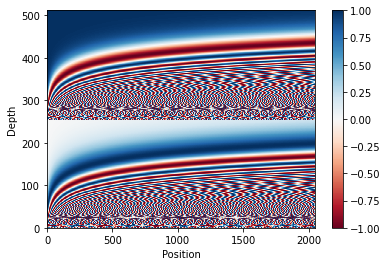

In [23]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

## Masking  قناع

Mask all the pad tokens in the batch of sequence.
قم بإخفاء جميع رموز اللوحة في مجموعة التسلسل.


 It ensures that the model does not treat padding as the input.
يضمن أن النموذج لا يتعامل مع الحشو كإدخال


The mask indicates where pad value `0` is present: it outputs a `1` at those locations, and a `0` otherwise.

يشير القناع إلى مكان وجود قيمة اللوحة "0": حيث ينتج "1" في تلك المواقع ، و "0" في الحالات الأخرى.

In [24]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [25]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

يتم استخدام قناع التطلع إلى الأمام لإخفاء الرموز المميزة المستقبلية في تسلسل. بمعنى آخر ، يشير القناع إلى الإدخالات التي لا يجب استخدامها.

This means that to predict the third token, only the first and second token will be used. هذا يعني أنه للتنبؤ بالرمز المميز الثالث ، سيتم استخدام الرمز المميز الأول والثاني فقط

Similarly to predict the fourth token, only the first, second and the third tokens will be used and so on.

In [26]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [27]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## Scaled dot product attention  تحجيم انتباه المنتج الداخلي



<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

The attention function used by the transformer takes three inputs: 
تأخذ وظيفة الانتباه التي يستخدمها المحول ثلاثة مدخلات

Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

يتم قياس انتباه المنتج النقطي بواسطة عامل الجذر التربيعي للعمق
يتم إجراء ذلك نظرًا لقيم العمق الكبيرة ، حيث ينمو المنتج النقطي بشكل كبير


For example, consider that `Q` and `K` have a mean of 0 and variance of 1.
على سبيل المثال ، ضع في اعتبارك أن لدينا متوسط 0 والتباين 1.

 Their matrix multiplication will have a mean of 0 and variance of `dk`. So the *square root of `dk`* is used for scaling, so you get a consistent variance regardless of the value of `dk`. If the variance is too low the output may be too flat to optimize effectively. If the variance is too high the softmax may saturate at initialization making it difficult to learn.

The mask is multiplied with -1e9 (close to negative infinity).
يتم ضرب القناع بـ -1e9 (قريب من اللانهاية السالبة)

 This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax.
 يتم ذلك لأن القناع يتم جمعه بضرب المصفوفة المقاس
 
  The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

  الهدف هو التخلص من هذه الخلايا ، وتكون المدخلات السلبية الكبيرة للوظيفة قريبة من الصفر في المخرجات. 

In [28]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights. احسب أوزان الانتباه
  q, k, v must have matching leading dimensions. يجب أن يكون لها أبعاد رائدة متطابقة
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v. 
  يجب أن يكون مطابقًا للبعد قبل الأخير

  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  القناع له أشكال مختلفة حسب نوعه (الحشو أو النظر للأمام)
   ولكن يجب أن يكون قابلاً للبث للإضافة

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns: عائدات
    output, attention_weights  الناتج ، أوزان الانتباه
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

As the softmax normalization is done on K, its values decide the amount of importance given to Q.

نظرًا لأن تطبيع 

softmax 

يتم على 

K ،

 فإن قيمه تحدد مقدار الأهمية المعطاة لـ
 
  Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the tokens you want to focus on are kept as-is and the irrelevant tokens are flushed out.

يمثل الناتج مضاعفة أوزان الانتباه والمتجه (القيمة). يضمن ذلك الاحتفاظ بالرموز المميزة التي تريد التركيز عليها كما هي وإزالة الرموز المميزة غير ذات الصلة.

In [29]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [30]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.*
# هذا "الاستعلام" يتوافق مع "المفتاح" الثاني ،
# لذلك يتم إرجاع "القيمة" الثانية.

temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [31]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
# يتوافق هذا الاستعلام مع المفتاح المكرر (الثالث والرابع) ،
# لذلك يتم حساب متوسط جميع القيم المرتبطة.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [32]:
# This query aligns equally with the first and second key,
# so their values get averaged.
# يتوافق هذا الاستعلام بالتساوي مع المفتاح الأول والثاني ،
# حتى يتم حساب متوسط قيمهم.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together. مرر جميع الاستفسارات معًا

In [33]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Multi-head attention  انتباه متعدد الرؤوس

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of three parts:
*    Linear layers طبقات خطية
*    Scaled dot-product attention تحجيم انتباه المنتج الداخلي
*    Final linear layer الطبقة الخطية النهائية

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers before the multi-head attention function.

In the diagram above `(K,Q,V)` are passed through sepearte linear (`Dense`) layers for each attention head. For simplicity/efficiency the code below implements this using a single dense layer with `num_heads` times as many outputs. The output is rearranged to a shape of `(batch, num_heads, ...)` before applying the attention function.

The `scaled_dot_product_attention` function defined above is applied in a single call, broadcasted for efficiency. An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information from different representation subspaces at different positions. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.


بدلاً من رأس انتباه واحد ، يتم تقسيم المتغيرات إلى رؤوس متعددة لأنها تسمح للنموذج بالحضور المشترك للمعلومات من فضاءات تمثيل فرعية مختلفة في مواقع مختلفة. بعد الانقسام ، يكون لكل رأس أبعاد مخفضة ، وبالتالي فإن التكلفة الإجمالية للحساب هي نفس تكلفة انتباه رأس واحد بأبعاد كاملة.

المتغيرات
K, V,K


In [34]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth) # (حجم الدفعة ، طول التسلسل ، عدد رؤوس ، العمق)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model) # (حجم الدفعة ، طول التسلسل ، النموذج)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.


قم بإنشاء طبقة  لتجربتها. في كل موقع في التسلسل ،  يدير  كل رؤوس الانتباه الثمانية عبر جميع المواقع الأخرى في التسلسل ، ويعيد متجهًا جديدًا بنفس الطول في كل موقع.

In [35]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model) # (حجم_دفعة ، تسلسل وحدة التشفير ، النموذج)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

## Point wise feed forward network
## شبكة تغذية نقطة إلى الأمام

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.
تتكون شبكة التغذية الأمامية من طبقتين متصلتين بالكامل

In [36]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [37]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## Encoder and decoder
## التشفير وفك التشفير

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](https://www.tensorflow.org/text/tutorials/nmt_with_attention.ipynb). 

يتبع نموذج المحول نفس النمط العام كتسلسل قياسي للتسلسل مع نموذج الانتباه.

* The input sentence is passed through `N` encoder layers that generates an output for each token in the sequence.
يتم تمرير جملة الإدخال عبر طبقات التشفير التي تولد مخرجات لكل رمز مميز في التسلسل.
* The decoder attends to the encoder's output and its own input (self-attention) to predict the next word. 

تهتم وحدة فك التشفير بإخراج جهاز التشفير ومدخلاته الخاصة (الاهتمام الذاتي) للتنبؤ بالكلمة التالية.

### Encoder layer طبقة التشفير

Each encoder layer consists of sublayers: تتكون كل طبقة تشفير من طبقات فرعية

1.   Multi-head attention (with padding mask)  
الانتباه متعدد الرؤوس (مع قناع الحشو)
2.    Point wise feed forward networks. 
شبكات تغذية نقطة إلى الأمام.

Each of these sublayers has a residual connection around it followed by a layer normalization. 
كل من هذه الطبقات الفرعية لها اتصال متبقي حولها متبوعًا بتطبيع الطبقة
Residual connections help in avoiding the vanishing gradient problem in deep networks.

تساعد الوصلات المتبقية في تجنب مشكلة التدرج المتلاشي في الشبكات العميقة.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [38]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [39]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

### Decoder layer

Each decoder layer consists of sublayers:
تتكون كل طبقة وحدة فك ترميز من طبقات فرعية:

1.   Masked multi-head attention (with look ahead mask and padding mask)
الانتباه متعدد الرؤوس المقنع (مع قناع النظر إلى الأمام وقناع الحشو)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output.
تمثل أوزان الانتباه الأهمية المعطاة لمدخلات مفكك الشفرات بناءً على النواتج المشفرات. 
 In other words, the decoder predicts the next token by looking at the encoder output and self-attending to its own output.
 بعبارة أخرى ، يتنبأ مفكك التشفير بالعلامة المميزة التالية من خلال النظر إلى خرج المشفر والانصراف الذاتي لمخرجاته
  See the demonstration above in the scaled dot product attention section.

In [40]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [41]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

### Encoder التشفير

The `Encoder` consists of:
1.   Input Embedding إدخال التضمين
2.   Positional Encoding ترميز موضعي
3.   N encoder layers طبقات التشفير

The input is put through an embedding which is summed with the positional encoding. يتم إدخال المدخلات من خلال التضمين الذي يتم تلخيصه بالتشفير الموضعي.

The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

ناتج هذا الجمع هو المدخلات إلى طبقات المشفر. إخراج المشفر هو المدخلات إلى وحدة فك التشفير.

In [42]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [43]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


### Decoder

 The `Decoder` consists of: فك
1.   Output Embedding  تضمين الإخراج
2.   Positional Encoding ترميز موضعي
3.   N decoder layers طبقات فك

The target is put through an embedding which is summed with the positional encoding. 
يتم وضع الهدف من خلال التضمين الذي يتم تلخيصه بالتشفير الموضعي.

The output of this summation is the input to the decoder layers.
ناتج هذا الجمع هو المدخلات إلى طبقات مفكك التشفير.
 The output of the decoder is the input to the final linear layer.
 خرج مفكك التشفير هو المدخل إلى الطبقة الخطية النهائية

In [44]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [45]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

## Create the Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

يتكون المحول من جهاز التشفير ومفكك التشفير وطبقة خطية نهائية. ناتج مفكك التشفير هو المدخل إلى الطبقة الخطية ويتم إرجاع ناتجها.

In [46]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs

    enc_padding_mask, look_ahead_mask, dec_padding_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, look_ahead_mask, dec_padding_mask

In [47]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for `num_layers, d_model, dff` have been reduced. 

The base model described in the [paper](https://arxiv.org/abs/1706.03762) used: `num_layers=6, d_model=512, dff=2048`.

In [48]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

استخدم مُحسِّن آدم مع جدولة معدل تعلم مخصصة وفقًا للصيغة الواردة في الورقة

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$


In [49]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [50]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

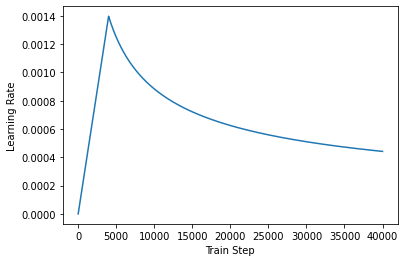

In [51]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

نظرًا لأن التسلسلات المستهدفة مبطنة ، فمن المهم تطبيق قناع حشو عند حساب الخسارة.

In [52]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [53]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [54]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training and checkpointing

In [55]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.
قم بإنشاء مسار نقطة التفتيش ومدير نقطة التفتيش. سيتم استخدام هذا لحفظ نقاط التفتيش في كل مرة.

In [56]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

The target is divided into tar_inp and tar_real.
الهدف مقسم إلى مدخلات مستهدفة وهدف حقيقي
tar_inp is passed as an input to the decoder.
 يتم تمرير إدخال الهدف كمدخل إلى وحدة فك التشفير
  `tar_real` is that same input shifted by 1:
  هو أن نفس الإدخال تم إزاحته بمقدار 1
   At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.
   في كل موقع يحتوي على الرمز المميز التالي الذي يجب توقعه.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next. 

المحول هو نموذج ارتداد ذاتي: يقوم بالتنبؤات جزء واحد في كل مرة ، ويستخدم مخرجاته حتى الآن لتقرير ما يجب القيام به بعد ذلك.

During training this example uses teacher-forcing (like in the [text generation tutorial](https://www.tensorflow.org/text/tutorials/text_generation)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

إن فرض المعلم هو تمرير الإخراج الحقيقي إلى الخطوة الزمنية التالية بغض النظر عما يتوقعه النموذج في الخطوة الزمنية الحالية.

As the transformer predicts each token, *self-attention* allows it to look at the previous tokens in the input sequence to better predict the next token.

نظرًا لأن المحول يتنبأ بكل رمز مميز ، فإن الاهتمام الذاتي يسمح له بالنظر إلى الرموز المميزة السابقة في تسلسل الإدخال للتنبؤ بشكل أفضل بالرمز المميز التالي.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

لمنع النموذج من إلقاء نظرة خاطفة على الإخراج المتوقع ، يستخدم النموذج قناع نظرة مستقبلية.

In [57]:
EPOCHS = 5

In [58]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

Portuguese is used as the input language and English is the target language.

In [59]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.8725 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.8141 Accuracy 0.0046
Epoch 1 Batch 100 Loss 8.7037 Accuracy 0.0243
Epoch 1 Batch 150 Loss 8.5847 Accuracy 0.0311
Epoch 1 Batch 200 Loss 8.4425 Accuracy 0.0346
Epoch 1 Batch 250 Loss 8.2718 Accuracy 0.0369
Epoch 1 Batch 300 Loss 8.0805 Accuracy 0.0384
Epoch 1 Batch 350 Loss 7.8840 Accuracy 0.0396
Epoch 1 Batch 400 Loss 7.6975 Accuracy 0.0459
Epoch 1 Batch 450 Loss 7.5315 Accuracy 0.0546
Epoch 1 Batch 500 Loss 7.3855 Accuracy 0.0629
Epoch 1 Batch 550 Loss 7.2547 Accuracy 0.0705
Epoch 1 Batch 600 Loss 7.1322 Accuracy 0.0788
Epoch 1 Batch 650 Loss 7.0165 Accuracy 0.0870
Epoch 1 Batch 700 Loss 6.9088 Accuracy 0.0946
Epoch 1 Batch 750 Loss 6.8106 Accuracy 0.1016
Epoch 1 Batch 800 Loss 6.7162 Accuracy 0.1080
Epoch 1 Loss 6.7003 Accuracy 0.1091
Time taken for 1 epoch: 228.01 secs

Epoch 2 Batch 0 Loss 5.2347 Accuracy 0.2217
Epoch 2 Batch 50 Loss 5.2057 Accuracy 0.2154
Epoch 2 Batch 100 Loss 5.1935 Accuracy 0.2171
Epoch 2 Batch

### Run inference

The following steps are used for inference: الإستنباط

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
قم بترميز جملة الإدخال باستخدام الرمز البرتغالي
* The decoder input is initialized to the `[START]` token.
تتم تهيئة إدخال وحدة فك التشفير إلى رمز البدء
* Calculate the padding masks and the look ahead masks.
احسب أقنعة الحشو وأقنعة التطلع إلى الأمام.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
ثم تُخرج "وحدة فك التشفير" التنبؤات من خلال النظر إلى "إخراج وحدة التشفير" ومخرجاتها الخاصة (الانتباه الذاتي).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
اربط الرمز المميز المتوقع بمدخل وحدة فك التشفير وقم بتمريره إلى وحدة فك التشفير.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.
في هذا النهج ، تتنبأ وحدة فك التشفير بالرمز المميز التالي بناءً على الرموز المميزة السابقة التي تنبأت بها.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

In [60]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=20):
    # input sentence is portuguese, hence adding the start and end token
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()
    
    encoder_input = sentence

    # as the target is english, the first token to the transformer should be the
    # english start token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)
    
    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)
      
      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    text = tokenizers.en.detokenize(output)[0]  # shape: ()

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop. So recalculate them outside
    # the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

Create an instance of this `Translator` class, and try it out a few times:
قم بإنشاء مثيل لفئة "المترجم" وجربها عدة مرات

In [61]:
translator = Translator(tokenizers, transformer)


In [62]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [63]:
sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem we have to solve .
Ground truth   : this is a problem we have to solve .


In [64]:
sentence = "os meus vizinhos ouviram sobre esta ideia."
ground_truth = "and my neighboring homes heard about this idea ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my own family heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


In [65]:
sentence = "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to share a lot of stories of a little bit of things that happened .
Ground truth   : so i 'll just share with you some stories very quickly of some magical things that have happened .


## Attention plots

The `Translator` class returns a dictionary of attention maps you can use to visualize the internal working of the model:

تعرض فئة "المترجم" قاموسًا لخرائط الانتباه التي يمكنك استخدامها لتصور العمل الداخلي للنموذج:

In [66]:
sentence = "este é o primeiro livro que eu fiz."
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


In [67]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [68]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

In [69]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

In [70]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

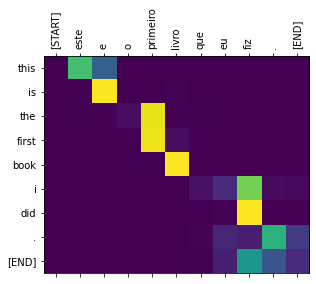

In [71]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [72]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

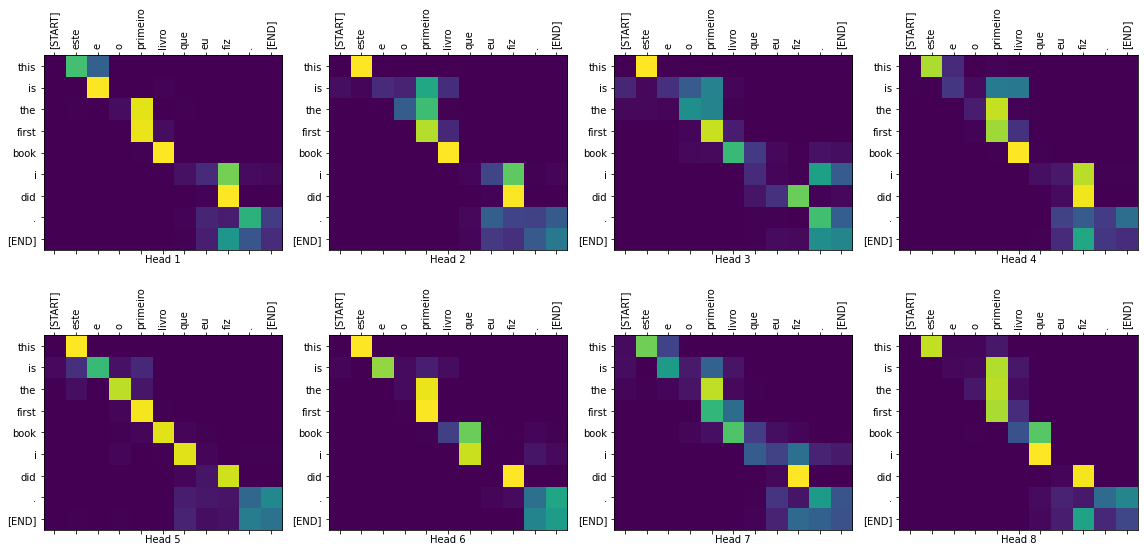

In [73]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

The model does okay on unfamiliar words. Neither "triceratops" or "encyclopedia" are in the input dataset and the model almost learns to transliterate them, even without a shared vocabulary:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i ' m going to be in the propot and imp .
Ground truth   : I read about triceratops in the encyclopedia.


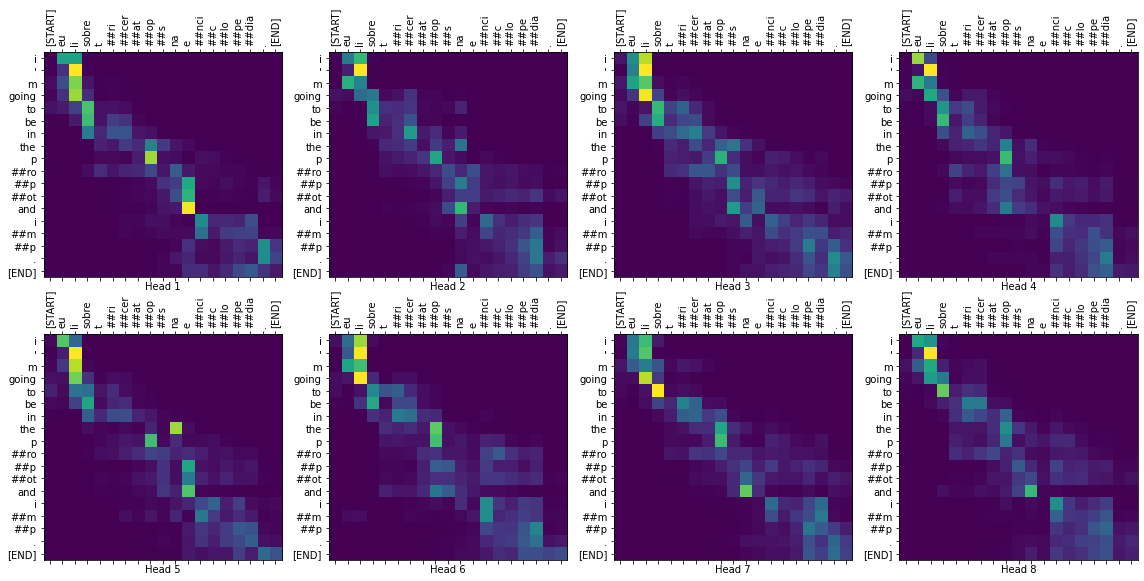

In [74]:
sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

## Export

That inference model is working, so next you'll export it as a `tf.saved_model`.

To do that, wrap it in yet another `tf.Module` sub-class, this time with a `tf.function` on the `__call__` method:

In [75]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result, 
     tokens,
     attention_weights) = self.translator(sentence, max_length=100)
    
    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

In [76]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [77]:
translator("este é o primeiro livro que eu fiz.").numpy()

b'this is the first book i did .'

In [78]:
tf.saved_model.save(translator, export_dir='translator')

In [79]:
reloaded = tf.saved_model.load('translator')

In [80]:
reloaded("este é o primeiro livro que eu fiz.").numpy()

b'this is the first book i did .'

## Summary

In this tutorial, you learned about positional encoding, multi-head attention, the importance of masking and how to create a transformer.


في هذا البرنامج التعليمي ، تعرفت على الترميز الموضعي ، والاهتمام متعدد الرؤوس ، وأهمية التقنيع وكيفية إنشاء محول.

Try using a different dataset to train the transformer. 
حاول استخدام مجموعة بيانات مختلفة لتدريب المحول.
You can also create the base transformer or transformer XL by changing the hyperparameters above.
يمكنك أيضًا إنشاء المحول الأساسي أو المحول الكبير عن طريق تغيير المعلمات الفائقة أعلاه
You can also use the layers defined here to create [BERT](https://arxiv.org/abs/1810.04805) and train state of the art models. Furthermore, you can implement beam search to get better predictions.
علاوة على ذلك ، يمكنك تنفيذ البحث بالحزمة للحصول على تنبؤات أفضل.